In [298]:
import torch
from torchvision import datasets, transforms

from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [2]:

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20000
set_size = 60000
batch_size = 2
sample_dir = 'samples'
save_dir = 'save'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])


# Data loader
# data_loader = torch.utils.data.DataLoader(dataset=mnist,
#                                          batch_size=batch_size, 
#                                          shuffle=True)
# Download MNIST dataset
mnist_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transform, 
                               download=True)
# Split original training set into 70% train and 30% validation
train_size = int(0.7 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Select a random image from the new training set
random_index = np.random.randint(len(train_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

mnist_images = train_dataloader.dataset.dataset.data
mnist_labels = train_dataset.dataset.targets


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert to tensor
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to Grayscale
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

train_dataset = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=transform, 
                               download=True)

# # Split original training set into 70% train and 30% validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # Select a random image from the new training set
# random_index = np.random.randint(len(train_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
cifar_images = torch.tensor(train_dataloader.dataset.dataset.data).permute(0, 3, 1, 2) / 255.0  # Convert to Tensor & Normalize

# cifar_images = train_dataloader.dataset.dataset.data
cifar_labels = train_dataset.dataset.targets

to_grayscale = transforms.Grayscale(num_output_channels=1)
cifar_gray = torch.stack([to_grayscale(img) for img in cifar_images])

AttributeError: 'CIFAR10' object has no attribute 'labels'

In [373]:
def compute_cdf_mapping(images):
    """
    Compute the CDF mapping for each pixel across all images.
    """
    
    vector_size = images.shape[1]
    images = images.view(-1, vector_size)  # Flatten images
    sorted_pixels, _ = torch.sort(images, dim=0)
    cdf = torch.linspace(0, 1, images.shape[0])
    pixel_cdf_map = {}
    
    for i in range(vector_size):
        pixel_cdf_map[i] = (sorted_pixels[:, i], cdf)
    
    return pixel_cdf_map

def transform_original_to_uniform(image, pixel_cdf_map, reverse=False):
    """
    Transform an image using the pixel CDF mapping.
    """
    image = image.view(-1)  # Flatten image
    transformed_image = torch.zeros_like(image, dtype=torch.float32)
    
    pixel_size = int(image.shape[0] ** 0.5)
    for i in range(pixel_size * pixel_size):
        pixel_values, cdf_values = pixel_cdf_map[i]
        
        if not reverse:
            # Forward transformation (find CDF value for each pixel)
            indices = torch.searchsorted(pixel_values, image[i])
            transformed_image[i] = cdf_values[min(indices, len(cdf_values) - 1)]
        else:
            # Reverse transformation (find original pixel from CDF value)
            indices = torch.searchsorted(cdf_values, image[i])
            transformed_image[i] = pixel_values[min(indices, len(pixel_values) - 1)]
    
    transformed_image = transformed_image.view(pixel_size, pixel_size)  # Reshape back to image size
    return transformed_image

def transform_uniform_to_gaussian(image, reverse=False):
    if not reverse:
        # Forward: Uniform [0,1] -> Gaussian N(0,1)
        if torch.min(image) < 0.0 or torch.max(image) > 1.0:
            raise ValueError("Input image values should be in the range [0,1] for forward transform.")
        gaussian_image = torch.erfinv(2 * image - 1) * torch.sqrt(torch.tensor(2.0))
        return gaussian_image

    else:
        # Reverse: Gaussian N(0,1) -> Uniform [0,1]
        reconstructed_image =  0.5 * (1 + torch.erf(image / torch.sqrt(torch.tensor(2.0))))
        return reconstructed_image





def compute_mean_and_covariance(images, epsilon=1e-4):
    """
    Compute the covariance matrix of the dataset, ensuring it is positive definite.
    """
    images = images.float()  # Ensure floating-point type
    images = images.view(images.shape[0], -1)  # Flatten images
    mean_vector = torch.mean(images, dim=0, keepdim=True)
    centered_images = images - mean_vector
    covariance_matrix = torch.matmul(centered_images.T, centered_images) / (images.shape[0] - 1)
    
    # Regularization: Add a small identity matrix to ensure positive definiteness
    covariance_matrix += epsilon * torch.eye(covariance_matrix.shape[0])
    
    return covariance_matrix, mean_vector

def generate_random_image(covariance_matrix, mean_vector):
    """
    Generate a random image where pixel values are uniform between 0 and 1,
    with a given covariance matrix.
    """
    pixel_size = int(covariance_matrix.shape[0] ** 0.5)
    gaussian_sample = torch.distributions.MultivariateNormal(mean_vector, covariance_matrix).sample()
    uniform_sample = 0.5 * (1 + torch.erf(gaussian_sample / np.sqrt(2)))  # Convert Gaussian to Uniform [0,1]
    gaussian_sample = gaussian_sample.view(pixel_size, pixel_size)
    uniform_sample = uniform_sample.view(pixel_size, pixel_size)
    return uniform_sample, gaussian_sample
def transform_dataset_to_uniform_vectorized(dataset):
    """
    Transform an entire dataset of images (tensor of shape (n, p, p)) so that for each pixel location,
    the empirical distribution of pixel values becomes uniform in [0,1].
    
    The transformation is performed using a double argsort to obtain the rank of each pixel value.
    
    Args:
        dataset (torch.Tensor): Tensor of shape (n, p, p)
        
    Returns:
        torch.Tensor: Transformed dataset with shape (n, p, p) where each pixel's value is in [0,1].
    """
    n, p, _ = dataset.shape
    # Flatten images: shape (n, p*p)
    flat_data = dataset.view(n, -1)
    
    # Compute the rank for each pixel across the dataset.
    # First argsort sorts the values; the second argsort recovers the rank.
    ranks = flat_data.argsort(dim=0).argsort(dim=0).float()
    
    # Normalize ranks to [0,1]
    uniform_flat = ranks / (n - 1)
    
    # Reshape back to (n, p, p)
    return uniform_flat.view(n, p, p)
import torch

def transform_dataset_to_uniform_and_gaussian_vectorized(dataset):
    """
    Transform an entire dataset of images (tensor of shape (n, p, p)) so that for each pixel location,
    the empirical distribution of pixel values becomes uniform in [0,1]. Then, using the relation
    z = sqrt(2) * erfinv(2u - 1), convert the uniform dataset into a Gaussian distributed dataset.
    
    Args:
        dataset (torch.Tensor): Tensor of shape (n, p, p)
        
    Returns:
        uniform_dataset (torch.Tensor): Transformed dataset with shape (n, p, p) with values in [0,1].
        gaussian_dataset (torch.Tensor): Dataset transformed to be Gaussian distributed.
    """
    n, p, _ = dataset.shape
    # Flatten images: shape (n, p*p)
    flat_data = dataset.view(n, -1)
    
    # Compute the rank for each pixel across the dataset via double argsort.
    # First argsort sorts the values; the second argsort recovers the rank.
    ranks = flat_data.argsort(dim=0).argsort(dim=0).float()
    
    # Normalize ranks to [0,1]
    uniform_flat = ranks / (n - 1)
    
    # Reshape back to (n, p, p)
    uniform_dataset = uniform_flat.view(n, p, p)
    
    # Convert the uniform dataset to Gaussian distributed data:
    # For each pixel, apply: z = sqrt(2) * erfinv(2u - 1)
    gaussian_dataset = torch.erfinv(2 * uniform_dataset - 1) * torch.sqrt(torch.tensor(2.0))
    
    return uniform_dataset, gaussian_dataset


def generate_uniform_iman_conover(covariance_matrix, n_samples=10000):
    """
    Generate a sample from a d-dimensional distribution with Uniform(0,1) marginals 
    whose covariance is approximately the given covariance_matrix.
    
    The method uses the Iman–Conover procedure.
    
    Args:
        covariance_matrix (np.ndarray): A d x d target covariance matrix.
            (For Uniform[0,1], the variance is 1/12, so the diagonal of covariance_matrix
            should be about 1/12.)
        n_samples (int): Number of samples to generate for the Iman–Conover adjustment.
        
    Returns:
        sample (np.ndarray): A d x 1 column vector drawn from the adjusted Uniform(0,1) distribution.
    """
    # Dimension (d) inferred from the covariance matrix
    d = covariance_matrix.shape[0]
    
    # For Uniform[0,1], variance = 1/12. So the target correlation matrix is:
    R_target = covariance_matrix * 12.0
    
    # Step 1: Generate independent Uniform(0,1) samples: shape (n_samples, d)
    U = np.random.uniform(0, 1, size=(n_samples, d))
    
    # Step 2: Standardize each column of U
    U_std = (U - U.mean(axis=0)) / U.std(axis=0, ddof=1)
    
    # Compute the empirical correlation matrix of U_std
    R_empirical = np.corrcoef(U_std, rowvar=False)
    
    # Step 3: Compute Cholesky factors for the empirical and target correlation matrices
    L_empirical = np.linalg.cholesky(R_empirical)
    L_target = np.linalg.cholesky(R_target)
    
    # Step 4: Compute the adjustment matrix
    A = L_target @ np.linalg.inv(L_empirical)
    
    # Adjust the standardized samples
    Z = U_std @ A.T
    
    # Step 5: For each variable (column), reassign values based on the ranks of Z,
    # so that the marginals remain Uniform(0,1) but the correlation structure is adjusted.
    U_adjusted = np.empty_like(U)
    for j in range(d):
        order = np.argsort(Z[:, j])
        sorted_vals = np.sort(U[:, j])
        U_adjusted[order, j] = sorted_vals
    
    # Step 6: Choose one sample (e.g., the first row) and return it as a column vector.
    sample = U_adjusted[0, :].reshape(-1, 1)
    uniform_random_image = torch.tensor(sample).view(-1)
    return uniform_random_image

import torch
import math

def generate_uniform_from_gaussian(covariance_matrix, epsilon=1e-4):
    """
    Given a target covariance matrix for Uniform(0,1) variables (with variance 1/12 on the diagonal),
    generate one d-dimensional sample (as a d x 1 column vector) using a multivariate Gaussian copula.
    The function uses vectorized operations to compute the Gaussian correlation matrix.
    
    Args:
        covariance_matrix (torch.Tensor): A d x d target covariance matrix for Uniform(0,1) variables.
            (For Uniform(0,1), the variance is 1/12, so the diagonal entries should be ~1/12.)
    
    Returns:
        torch.Tensor: A d x 1 column vector sample with values in [0,1].
    """
    d = covariance_matrix.shape[0]
    # Compute target correlation matrix for Uniform variables.
    # For Uniform[0,1], variance = 1/12, so multiply by 12.
    R_U = covariance_matrix * 12.0

    # Vectorized computation of Gaussian correlation matrix:
    R_gauss = 2 * torch.sin((math.pi/6) * R_U) + epsilon*torch.eye(d)
    
    # Generate one sample from the multivariate Gaussian N(0, R_gauss)
    mean = torch.zeros(d)
    mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=R_gauss)
    z = mvn.sample()  # shape: (d,)
    
    # Convert the Gaussian sample to Uniform(0,1) using the Gaussian CDF:
    U = 0.5 * (1 + torch.erf(z / math.sqrt(2)))
    
    # Return as a d x 1 column vector
    return U.unsqueeze(1)

In [5]:
# set_name = 'cifar'
# set_name = 'mnist'
# num_samples = 20000
# ifsave = False
# ifsave = True

# if set_name == 'mnist':
#     images = mnist_images
#     path_name_uniform  = 'mnist_uniform_images.pth'
#     path_name_gaussian = 'mnist_gaussian_images.pth'
# elif set_name == 'cifar':
#     images = torch.tensor(cifar_gray).squeeze(dim=1)
#     path_name_uniform  = 'cifar_uniform_images.pth'
#     path_name_gaussian = 'cifar_gaussian_images.pth'
# train_images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
# print(train_images.shape)
# pixel_cdf_map = compute_cdf_mapping(train_images)


# # uniform_images = torch.stack([transform_original_to_uniform(img, pixel_cdf_map) for img in train_images])
# uniform_images = transform_dataset_to_uniform_vectorized(mnist_images)
# gaussian_images = torch.stack([transform_uniform_to_gaussian(img, pixel_cdf_map) for img in uniform_images])
# if ifsave:
#     torch.save(gaussian_images, path_name_gaussian)
#     torch.save(uniform_images, path_name_uniform)

# uniform_images = torch.load(path_name_uniform)
# # gaussian_images = torch.load(path_name_gaussian)
# # uniform_images = torch.load(path_name_uniform)

# # gaussian_images[gaussian_images > 10000] = 10000
# # gaussian_images[gaussian_images <- 10000] = -10000

In [9]:

set_name = 'cifar'
set_name = 'mnist'
if set_name == 'mnist':
    images = mnist_images
    path_name_uniform  = 'mnist_uniform_images.pth'
    path_name_gaussian = 'mnist_gaussian_images.pth'
elif set_name == 'cifar':
    images = torch.tensor(cifar_gray).squeeze(dim=1)
    path_name_uniform  = 'cifar_uniform_images.pth'
    path_name_gaussian = 'cifar_gaussian_images.pth'
train_images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
random_index = np.random.randint(len(train_images))
pixel_size = int(train_images[random_index].shape[0] **0.5)
pixel_cdf_map = compute_cdf_mapping(train_images)
sample_image = train_images[random_index].reshape(pixel_size, pixel_size)
transformed_image_uniform = transform_original_to_uniform(sample_image, pixel_cdf_map)
transformed_image_gaussian = transform_uniform_to_gaussian(transformed_image_uniform)
reconstructed_image_uniform = transform_original_to_uniform(transformed_image_uniform, pixel_cdf_map, reverse=True)
reconstructed_image_gaussian_tmp = transform_uniform_to_gaussian(transformed_image_gaussian, reverse=True)
reconstructed_image_gaussian = transform_original_to_uniform(reconstructed_image_gaussian_tmp, pixel_cdf_map, reverse=True)

tmp =  sample_image - reconstructed_image_gaussian


# fig, axs = plt.subplots(1, 5, figsize=(15, 10))
# axs[0].imshow(sample_image, cmap='gray')
# axs[0].set_title('Original')
# axs[1].imshow(transformed_image_uniform, cmap='gray')
# axs[1].set_title('Transformed (Uniform)')
# axs[3].imshow(transformed_image_gaussian, cmap='gray')
# axs[3].set_title('Transformed (Gaussian)')
# axs[2].imshow(reconstructed_image_uniform, cmap='gray')
# axs[2].set_title('Reconstructed (Uniform)')
# axs[4].imshow(reconstructed_image_gaussian, cmap='gray')
# axs[4].set_title('Reconstructed (Gaussian)')
# plt.show() 
# fig, axs = plt.subplots(1, 3, figsize=(10, 10))
# axs[0].imshow(sample_image, cmap='gray')
# axs[0].set_title('Real Image')
# axs[1].imshow(synthetic_image_from_uniform, cmap='gray')
# axs[1].set_title('Fake Image (Uniform)')
# axs[2].imshow(synthetic_image_from_gaussian, cmap='gray')
# axs[2].set_title('Gaussian')
# plt.show()
# fig, axs = plt.subplots(1,1, figsize=(5,5))
# axs.imshow(synthetic_image_from_uniform, cmap='gray')
# axs.set_title('Fake Image (Uniform)')
# plt.show()

/tmp/ipykernel_76436/3471115640.py:30: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:38.)
  indices = torch.searchsorted(pixel_values, image[i])


In [11]:
# from scipy.linalg import sqrtm
# def compute_transformation_matrix(covariance_matrix_data):
#     """
#     Given:
#       S_y: Diagonal covariance matrix of y (numpy array of shape (n, n))
#       Sigma: Desired covariance matrix of z = A y (numpy array of shape (n, n))
    
#     Returns:
#       A: Transformation matrix such that Cov(z) = A S_y A^T = Sigma.
#     """
#     # Extract the diagonal values from S_y and compute S_y^(-1/2)
#     # diag_vals = np.diag(S_y)
#     # S_y_inv_sqrt = np.diag(1.0 / np.sqrt(diag_vals))
    
#     # Compute the square root of Sigma
#     Sigma_sqrt = sqrtm(covariance_matrix_data)
    
#     # Compute A = Sigma^(1/2) * S_y^(-1/2)
#     A = Sigma_sqrt #@ S_y_inv_sqrt
#     A = A 
#     return torch.tensor(A)
# def normalize_image_to_255(image):
#     """
#     Normalize a torch tensor image such that its pixel values are scaled to [0, 255].
    
#     Args:
#         image (torch.Tensor): Input image tensor.
    
#     Returns:
#         torch.Tensor: Normalized image with pixel values in [0, 255] and type torch.uint8.
#     """
#     # Compute minimum and maximum pixel values
#     min_val = torch.min(image)
#     max_val = torch.max(image)
    
#     # Avoid division by zero if the image is constant
#     if max_val - min_val == 0:
#         normalized = torch.zeros_like(image)
#     else:
#         # Scale the image to [0, 1]
#         normalized = (image - min_val) / (max_val - min_val)
    
#     # Scale to [0, 255] and convert to uint8
#     scaled = (normalized * 255).to(torch.uint8)
#     return scaled


In [ ]:
a

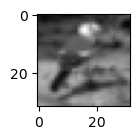

In [366]:
label_idx = 2
images = cifar_gray[torch.tensor(cifar_labels) == label_idx].squeeze(dim=1)
fig, ax = plt.subplots(1,1, figsize=(1.2,1.2))
plt.imshow(images[np.random.randint(len(images))], cmap='gray')

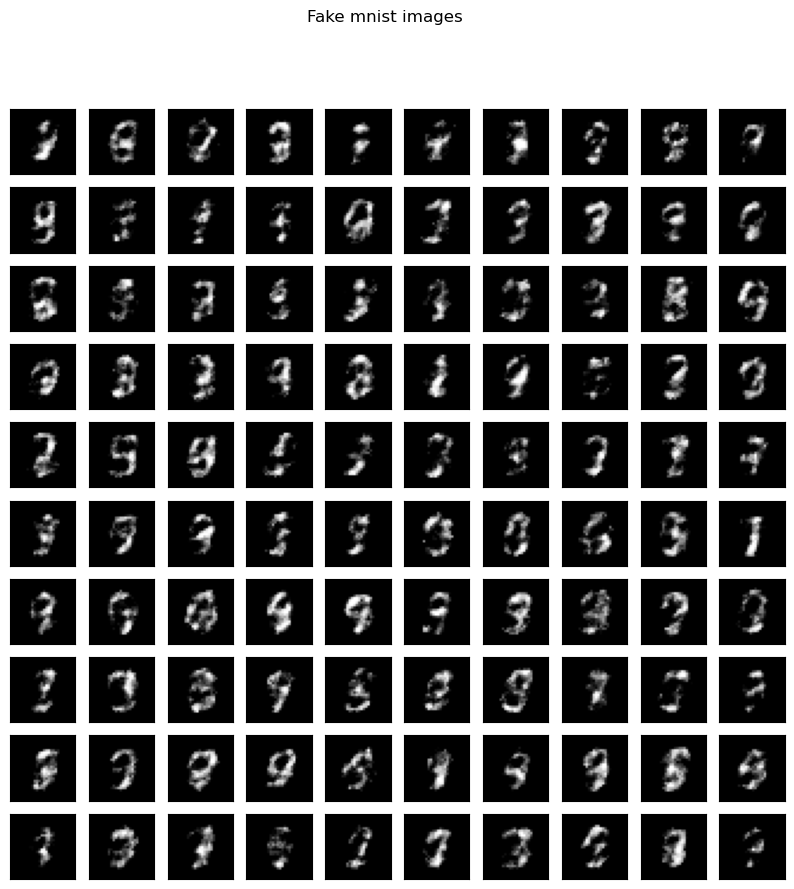

In [390]:
set_name = 'cifar'
set_name = 'mnist'
label_idx = 4
if set_name == 'mnist':
    images = mnist_images
    # images = mnist_images[mnist_labels == label_idx]
elif set_name == 'cifar':
    images = cifar_gray.squeeze(dim=1)
    images = cifar_gray[torch.tensor(cifar_labels) == label_idx].squeeze(dim=1)
train_images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
pixel_cdf_map = compute_cdf_mapping(train_images)




uniform_images, _ = transform_dataset_to_uniform_and_gaussian_vectorized(images)


covariance_matrix_uniform, mean_uniform = compute_mean_and_covariance(uniform_images, epsilon = 0.0000001)
number_of_rows_or_columns = 10
fig, axs = plt.subplots(number_of_rows_or_columns, number_of_rows_or_columns, figsize=(number_of_rows_or_columns, number_of_rows_or_columns))
idx = 0
for idx_i in range(number_of_rows_or_columns):
    for idx_j in range (0, number_of_rows_or_columns,1):
        idx += 1
        print(f"Image {idx}/{number_of_rows_or_columns**2}" , end="\r")
        # uniform_random_image = generate_uniform_iman_conover(covariance_matrix_uniform, n_samples=2000)
        uniform_random_image, gaussian_random_image = generate_random_image(covariance_matrix_uniform, 0*mean_uniform)
        # uniform_random_image =  generate_uniform_from_gaussian(covariance_matrix_uniform, epsilon=0.000001)
        synthetic_image_from_uniform = transform_original_to_uniform(uniform_random_image.squeeze(), pixel_cdf_map, reverse=True)
        axs[idx_i,idx_j].imshow(synthetic_image_from_uniform, cmap='gray')
        # axs[idx_i,idx_j].set_title('Uniform', fontsize=10)
        axs[idx_i,idx_j].set_xticks([])  # Hide x-ticks
        axs[idx_i,idx_j].set_yticks([])  # Hide x-ticks
fig.suptitle('Fake ' + set_name + ' images')
fig.savefig('fake-' + set_name + '-images.pdf')


In [228]:
# set_name = 'cifar'
# # set_name = 'mnist'
# label_idx = 2
# if set_name == 'mnist':
#     images = mnist_images
#     # images = mnist_images[mnist_labels == label_idx]
# elif set_name == 'cifar':
#     images = cifar_gray[torch.tensor(cifar_labels) == label_idx].squeeze(dim=1)
#     images = cifar_gray.squeeze(dim=1)
# train_images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
# pixel_cdf_map = compute_cdf_mapping(train_images)




# uniform_images, gaussian_images = transform_dataset_to_uniform_and_gaussian_vectorized(images)

# # gaussian_images = torch.stack([transform_uniform_to_gaussian(img, pixel_cdf_map) for img in uniform_images])
# covariance_matrix_gaussian, mean_gaussian = compute_mean_and_covariance(gaussian_images, epsilon = 0.000001)
# covariance_matrix_uniform, mean_uniform = compute_mean_and_covariance(uniform_images, epsilon = 0.000001)
# covariance_matrix_data, mean_data = compute_mean_and_covariance(train_images, epsilon = 0.0001)
# # transformation_matrix = compute_transformation_matrix(covariance_matrix_data)
# identity_matrix = torch.eye(train_images.shape[1])
# pixel_size = int(train_images.shape[1]**0.5)
# zero_vector = torch.zeros(train_images.shape[1])
# number_of_columns = 8
# number_of_rows = 15
# fig, axs = plt.subplots(number_of_rows, 2*number_of_columns, figsize=(8,8))
# idx = -1
# for idx_i in range(number_of_rows):
#     for idx_j in range (0, 2*number_of_columns,2):
#         idx += 1
#         # uniform_random_image, gaussian_random_image = generate_random_image(identity_matrix, zero_vector)
#         uniform_random_image, gaussian_random_image = generate_random_image(covariance_matrix_uniform, 0*mean_uniform)
#         # uniform_random_image, gaussian_random_image = generate_random_image(covariance_matrix_gaussian, 0*mean_uniform)
#         synthetic_image_from_uniform = transform_original_to_uniform(uniform_random_image, pixel_cdf_map, reverse=True)
#         uniform_image_from_gaussian = transform_uniform_to_gaussian(gaussian_random_image, reverse=True)
#         # uniform_image_from_gaussian  = (torch.matmul(transformation_matrix, uniform_image_from_gaussian.reshape(-1)).reshape(pixel_size, pixel_size))
#         synthetic_image_from_gaussian  = transform_original_to_uniform(uniform_image_from_gaussian, pixel_cdf_map, reverse=True)
#         # print(synthetic_image_from_uniform.min(), synthetic_image_from_uniform.max(), synthetic_image_from_gaussian.min(), synthetic_image_from_gaussian.max())
#         # synthetic_image_from_gaussian  = (torch.matmul(transformation_matrix.real, synthetic_image_from_gaussian.reshape(-1)).reshape(pixel_size, pixel_size))
#         # synthetic_image_from_uniform  = normalize_image_to_255(torch.matmul(covariance_matrix_data, synthetic_image_from_uniform.reshape(-1)).reshape(pixel_size, pixel_size))
#         # print(synthetic_image_from_gaussian.min(), synthetic_image_from_gaussian.max())
#         axs[idx_i,idx_j].imshow(synthetic_image_from_uniform, cmap='gray')
#         # axs[idx_i,idx_j].set_title('Uniform', fontsize=10)
#         axs[idx_i,idx_j].set_xticks([])  # Hide x-ticks
#         axs[idx_i,idx_j].set_yticks([])  # Hide x-ticks
#         axs[idx_i,idx_j+1].imshow(synthetic_image_from_gaussian, cmap='gray')
#         # axs[idx_i,idx_j+1].set_title('Gaussian', fontsize=10)
#         axs[idx_i,idx_j+1].set_xticks([])  # Hide x-ticks
#         axs[idx_i,idx_j+1].set_yticks([])  # Hide x-ticks
# fig.suptitle('Fake ' + set_name + ' images')
# fig.savefig('fake-' + set_name + '-images.pdf')



tensor([[[ 0.6139,  0.6364,  0.6662,  ...,  0.6844,  0.6662,  0.6230],
         [ 0.6794,  0.7178,  0.7289,  ...,  0.7680,  0.7407,  0.6813],
         [ 0.7593,  0.8091,  0.8322,  ...,  0.8472,  0.8280,  0.7809],
         ...,
         [ 1.1551,  1.0883,  0.8755,  ...,  1.6685,  1.6526,  1.6090],
         [ 1.1551,  1.1709,  1.1689,  ...,  1.5821,  1.5682,  1.5447],
         [ 1.0993,  1.1358,  1.1396,  ...,  1.5219,  1.5172,  1.4923]],

        [[-0.6024, -0.6438, -0.6036,  ..., -0.6420, -0.7023, -0.7289],
         [-0.6637, -0.6933, -0.6687,  ..., -0.6413, -0.6605, -0.7387],
         [-0.6599, -0.6463, -0.6643,  ..., -0.5976, -0.6376, -0.6724],
         ...,
         [-0.1991, -0.1833, -0.1599,  ..., -0.0796, -0.2412, -0.3781],
         [-0.2094, -0.1746, -0.1711,  ..., -0.1579, -0.2614, -0.3647],
         [-0.2227, -0.2165, -0.1843,  ..., -0.1548, -0.1736, -0.2418]],

        [[ 1.4772,  1.4380,  1.4199,  ...,  0.5340,  1.1729,  1.3581],
         [ 1.4465,  1.4131,  1.4310,  ...,  0

ValueError: supplied range of [-inf, inf] is not finite

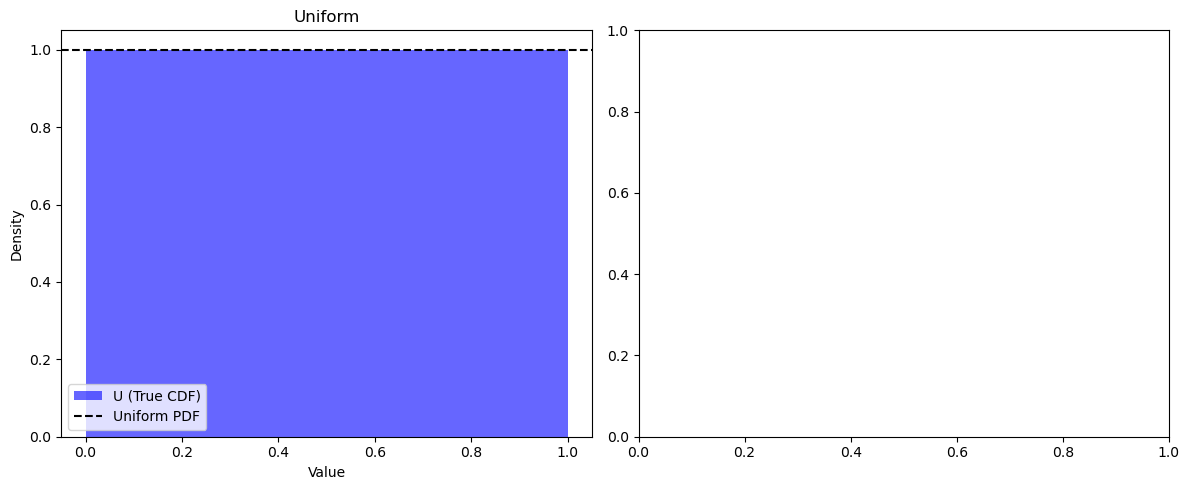

In [229]:
print(gaussian_images)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# Plot U (true CDF)
ax1.hist(uniform_images.flatten(), bins=50, density=True, alpha=0.6, color='blue', label='U (True CDF)')
ax1.axhline(1.0, color='black', linestyle='--', label='Uniform PDF')  # Expected density for U
ax1.set_title('Uniform')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
ax1.legend()

# Plot V (approximated)
ax2.hist(gaussian_images.flatten(), bins=50, density=True, alpha=0.6, color='red', label='V (Approximated)')
ax2.set_title('Gaussian')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')
ax2.legend()

plt.show()